# Clusterización en un dataset de equipos de baloncesto

Pasos a seguir:
1. Hacer un análisis exploratorio para revisar la estructura de los datos
2. Usar lo que observamos para guiar nuestro proceso de agrupamiento
3. Ajustar un algortimo de k-means a los datos disponibles

**Fuente del dataset:** [Kaggle-College Basketball Dataset](https://www.kaggle.com/andrewsundberg/college-basketball-dataset)

**Contexto:** Las competencias deportivas cada día recogen una gran cantidad de datos relacionados con el desempeño de sus equipos y jugadores para encontrar patrones en estos datos y tomar decisiones informadas basadas en ellos. De esta manera la competencia aumenta tanto dentro como fuera de la cancha

**Problema de negocio:** Se tienen los datos de desempeño de los equipos de baloncesto del torneo NCAA March Madness que contiene las estadísticas de juego de 353 equipos de la liga. El objetivo es inspeccionar esta data utilizando técnicas de visualización y agrupación para encontrar patrones en el desempeño de los equipos y generar recomendaciones de umbrales en las estadísticas para que un equipo esté en el grupo de desempeño superior.

In [1]:
# librerías
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import sklearn
from scipy.stats import norm
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, RobustScaler, StandardScaler
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from matplotlib import pyplot as plt

 ## Datos
 
Estas son las variables que contiene el conjunto de datos

- **TEAM:** Equipo
- **CONF:** La conferencia en la que el equipo participa(A10 = Atlantic 10, ACC = Atlantic Coast Conference, AE = America East, Amer = American, ASun = ASUN, B10 = Big Ten, B12 = Big 12, BE = Big East, BSky = Big Sky, BSth = Big South, BW = Big West, CAA = Colonial Athletic Association, CUSA = Conference USA, Horz = Horizon League, Ivy = Ivy League, MAAC = Metro Atlantic Athletic Conference, MAC = Mid-American Conference, MEAC = Mid-Eastern Athletic Conference, MVC = Missouri Valley Conference, MWC = Mountain West, NEC = Northeast Conference, OVC = Ohio Valley Conference, P12 = Pac-12, Pat = Patriot League, SB = Sun Belt, SC = Southern Conference, SEC = South Eastern Conference, Slnd = Southland Conference, Sum = Summit League, SWAC = Southwestern Athletic Conference, WAC = Western Athletic Conference, WCC = West Coast Conference)
- **G:** Número de partidos jugados
- **W:** Número de partidos ganados
- **ADJOE:** Estimación de eficiencia ofensiva, puntos anotados por cada 100 posesiones
- **ADJDE:** Estimación de eficiencia defensiva, puntos permitidos por cada 100 posesiones del equipo contrario
- **BARTHAG:** Probabilidad de vencer a un equipo
- **EFG_O:** Effective Field Goal Percentage Shot
- **EFG_D:** Effective Field Goal Percentage Allowed
- **TOR:** Porcentaje de rotación permitida (equipo pierde la posesión del balón contra el equipo contrario antes de que un jugador dispare a la canasta de su equipo)
- **TORD:** Porcentaje de rotación hecha al equipo contrario (se roba la pelota al contrincante)
- **ORB:** Porcentaje de rebote ofensivo
- **B:** Porcentaje de rebote defensivo
- **FTR:** Tasa de tiros libres hechos(que hace el equipo)
- **FTRD:** Tasa de tiros libres permitidos (que hace el contrincante)
- **2P_O:** Porcentaje de tiros de 2 puntos hechos
- **2P_D:** Porcentaje de tiros de 2 puntos permitidos
- **3P_O:** Porcentaje de tiros de 3 puntos hechos
- **3P_D:** Porcentaje de tiros de 3 puntos permitidos
- **ADJ_T:** Posesión del balón por 40 min
- **WAB:** Triunfos por encima de la 'burbuja' (la burbuja es el límite definido para pasar al campeonato NCAA March Madness Tournament
- **POSTSEASON:** Ronda en la que el equipo de fue eliminado (R68 = First Four, R64 = Round of 64, R32 = Round of 32, S16 = Sweet Sixteen, E8 = Elite Eight, F4 = Final Four, 2ND = Runner-up, Champion = Winner of the NCAA March Madness Tournament for that given year)
- **SEED:** Semilla definida por el torneo

In [2]:
datos = pd.read_csv('data/basketball_19.csv')
datos.head()

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,...,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED
0,Gonzaga,WCC,37,33,123.4,89.9,0.9744,59.0,44.2,14.9,...,35.3,25.9,61.4,43.4,36.3,30.4,72.0,7.0,E8,1.0
1,Virginia,ACC,38,35,123.0,89.9,0.9736,55.2,44.7,14.7,...,29.1,26.3,52.5,45.7,39.5,28.9,60.7,11.1,Champions,1.0
2,Duke,ACC,38,32,118.9,89.2,0.9646,53.6,45.0,17.5,...,33.2,24.0,58.0,45.0,30.8,29.9,73.6,11.2,E8,1.0
3,North Carolina,ACC,36,29,120.1,91.4,0.9582,52.9,48.9,17.2,...,30.2,28.4,52.1,47.9,36.2,33.5,76.0,10.0,S16,1.0
4,Michigan,B10,37,30,114.6,85.6,0.9665,51.6,44.1,13.9,...,27.5,24.1,51.8,44.3,34.2,29.1,65.9,9.2,S16,2.0


## Exploración de datos
Para empezar el análisis hay que hacer una exploración inicial de los datos, entender un poco las variables y la información que tenemos. Para empezar nuestros datos consisten en las estadísticas de 353 equipos contenidas en 23 variables

In [3]:
datos.shape

(353, 23)

In [4]:
datos.describe()

,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,SEED
count,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,68.000000
mean,31.745042,17.113314,103.335977,103.336261,0.493214,50.600850,50.774504,18.606516,18.523513,28.245892,28.420397,32.954391,33.202550,50.060057,50.233994,34.287819,34.415864,69.168555,-7.783569,8.794118
std,2.514195,6.374993,7.020019,6.452597,0.253006,2.938629,2.752896,2.066711,2.092719,3.938373,2.923335,4.708719,5.080133,3.362801,3.122286,2.537098,2.336075,2.694397,7.120550,4.698551
min,26.000000,3.000000,83.700000,85.200000,0.034600,40.000000,42.500000,13.500000,13.300000,15.900000,21.700000,21.900000,21.800000,37.700000,40.700000,27.900000,27.900000,60.700000,-23.400000,1.000000
25%,30.000000,12.000000,98.600000,98.700000,0.281400,48.800000,48.900000,17.200000,17.100000,25.400000,26.300000,29.900000,29.700000,47.700000,48.300000,32.400000,32.900000,67.300000,-13.100000,5.000000
50%,31.000000,17.000000,103.100000,104.000000,0.476200,50.500000,50.900000,18.500000,18.300000,28.300000,28.300000,33.300000,32.700000,50.300000,50.200000,34.200000,34.400000,69.000000,-8.600000,9.000000
75%,33.000000,21.000000,107.700000,107.800000,0.689300,52.800000,52.600000,19.800000,19.800000,31.000000,30.400000,35.900000,36.400000,52.200000,52.200000,36.000000,35.900000,70.800000,-3.100000,13.000000
max,39.000000,35.000000,123.400000,119.200000,0.974400,59.000000,59.300000,25.100000,24.700000,38.700000,37.100000,48.100000,54.000000,61.400000,61.200000,42.400000,41.800000,79.100000,11.200000,16.000000


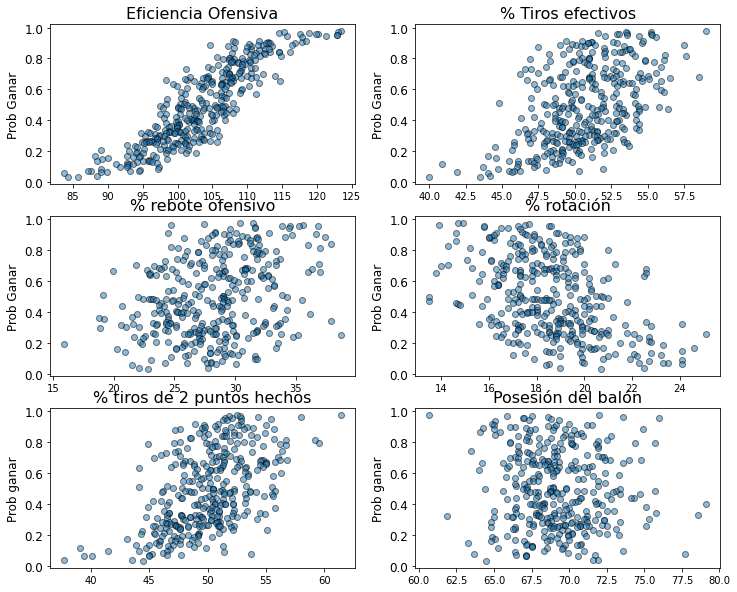

In [5]:
# Cómo se relacionan algunas variables con la probabilidad de ganar
plt.figure(figsize=(12,10))

plt.subplot(321)
plt.scatter(y=datos['BARTHAG'], x=datos['ADJOE'],alpha=0.5, edgecolor='k')
plt.yticks(fontsize=12)
plt.ylabel('Prob Ganar', fontsize=12)
plt.title('Eficiencia Ofensiva', fontsize=16)

plt.subplot(322)
plt.scatter(y=datos['BARTHAG'], x=datos['EFG_O'],alpha=0.5, edgecolor='k')
plt.yticks(fontsize=12)
plt.ylabel('Prob Ganar', fontsize=12)
plt.title('% Tiros efectivos', fontsize=16)


plt.subplot(323)
plt.scatter(y=datos['BARTHAG'], x=datos['ORB'],alpha=0.5, edgecolor='k')
plt.yticks(fontsize=12)
plt.ylabel('Prob Ganar', fontsize=12)
plt.title('% rebote ofensivo', fontsize=16)


# Partidos ganados
plt.subplot(324)
plt.scatter(y=datos['BARTHAG'], x=datos['TOR'],alpha=0.5, edgecolor='k')
plt.ylabel('Prob Ganar', fontsize=12)
plt.yticks(fontsize=12)
plt.title('% rotación', fontsize=16)


plt.subplot(325)
plt.scatter(y=datos['BARTHAG'], x=datos['2P_O'],alpha=0.5, edgecolor='k')
plt.ylabel('Prob ganar', fontsize=12)
plt.yticks(fontsize=12)
plt.title('% tiros de 2 puntos hechos', fontsize=16)


plt.subplot(326)
plt.scatter(y=datos['BARTHAG'], x=datos['ADJ_T'],alpha=0.5, edgecolor='k')
plt.ylabel('Prob ganar', fontsize=12)
plt.yticks(fontsize=12)
plt.title('Posesión del balón', fontsize=16)


plt.show()

In [6]:
km_data = datos.drop(['TEAM','CONF','POSTSEASON','SEED'],axis=1)
km_data.head()

,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB
0,37,33,123.4,89.9,0.9744,59.0,44.2,14.9,19.0,31.5,26.8,35.3,25.9,61.4,43.4,36.3,30.4,72.0,7.0
1,38,35,123.0,89.9,0.9736,55.2,44.7,14.7,17.5,30.4,25.4,29.1,26.3,52.5,45.7,39.5,28.9,60.7,11.1
2,38,32,118.9,89.2,0.9646,53.6,45.0,17.5,19.4,35.6,29.5,33.2,24.0,58.0,45.0,30.8,29.9,73.6,11.2
3,36,29,120.1,91.4,0.9582,52.9,48.9,17.2,18.3,35.3,22.8,30.2,28.4,52.1,47.9,36.2,33.5,76.0,10.0
4,37,30,114.6,85.6,0.9665,51.6,44.1,13.9,18.0,24.7,24.8,27.5,24.1,51.8,44.3,34.2,29.1,65.9,9.2


In [7]:
corr = km_data.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB
G,1.00,0.67,0.64,-0.63,0.71,0.32,-0.50,-0.32,0.18,0.29,-0.14,0.20,-0.21,0.32,-0.48,0.16,-0.34,-0.05,0.70
W,0.67,1.00,0.75,-0.68,0.79,0.59,-0.65,-0.46,0.23,0.32,-0.29,0.15,-0.26,0.57,-0.57,0.36,-0.51,-0.03,0.90
ADJOE,0.64,0.75,1.00,-0.57,0.88,0.70,-0.39,-0.58,-0.03,0.30,-0.21,0.07,-0.40,0.64,-0.36,0.47,-0.29,0.02,0.85
ADJDE,-0.63,-0.68,-0.57,1.00,-0.87,-0.23,0.82,0.22,-0.26,-0.26,0.31,-0.11,0.18,-0.30,0.74,-0.03,0.62,0.15,-0.83
BARTHAG,0.71,0.79,0.88,-0.87,1.00,0.51,-0.66,-0.45,0.13,0.31,-0.28,0.10,-0.33,0.52,-0.60,0.27,-0.50,-0.07,0.94
EFG_O,0.32,0.59,0.70,-0.23,0.51,1.00,-0.18,-0.36,-0.12,-0.11,-0.28,-0.05,-0.42,0.88,-0.16,0.73,-0.14,0.02,0.51
EFG_D,-0.50,-0.65,-0.39,0.82,-0.66,-0.18,1.00,0.13,-0.08,-0.25,0.21,-0.15,0.12,-0.23,0.89,-0.03,0.77,0.12,-0.69
TOR,-0.32,-0.46,-0.58,0.22,-0.45,-0.36,0.13,1.00,0.07,0.20,0.18,0.20,0.39,-0.28,0.11,-0.32,0.10,-0.03,-0.44
TORD,0.18,0.23,-0.03,-0.26,0.13,-0.12,-0.08,0.07,1.00,0.18,0.35,0.16,0.39,-0.04,-0.03,-0.18,-0.14,0.00,0.17
ORB,0.29,0.32,0.30,-0.26,0.31,-0.11,-0.25,0.20,0.18,1.00,0.05,0.25,0.17,-0.02,-0.25,-0.18,-0.17,-0.01,0.36


## Agrupamiento

A partir del análisis exploratorio, escogemos algunas variables que parecen tener una mayor variabilidad y nos permitirán identificar tipos de equipos

In [8]:
km = km_data[['W','ADJOE','BARTHAG','EFG_O','2P_O','WAB']]
km.head()

,W,ADJOE,BARTHAG,EFG_O,2P_O,WAB
0,33,123.4,0.9744,59.0,61.4,7.0
1,35,123.0,0.9736,55.2,52.5,11.1
2,32,118.9,0.9646,53.6,58.0,11.2
3,29,120.1,0.9582,52.9,52.1,10.0
4,30,114.6,0.9665,51.6,51.8,9.2


In [9]:
scaler = StandardScaler()
km_scale = scaler.fit_transform(km)
km_scale[0:5]

array([[2.49556925, 2.86217223, 1.90457765, 2.86224391, 3.37695893,
        2.07913073],
       [2.80974042, 2.80511144, 1.90141118, 1.56728827, 0.72659873,
        2.65574628],
       [2.33848367, 2.22023839, 1.86578838, 1.02204379, 2.36446178,
        2.66981008],
       [1.86722692, 2.39142075, 1.84045661, 0.78349933, 0.60748142,
        2.50104455],
       [2.0243125 , 1.60683495, 1.87330875, 0.34048819, 0.51814344,
        2.3885342 ]])

## K-Means

In [10]:
kmeans = KMeans(
        #init = "kmean++"
        init="random",
        n_clusters=3,
        random_state=42  #semilla
    )

In [11]:
kmeans.fit(km_scale)

KMeans(init='random', n_clusters=3, random_state=42)

In [12]:
print('La suma de distancias cuadradas de cada punto a su centroide en esta solución es de')
print(kmeans.inertia_)
print('Pero este número por si solo no es muy explicativo')

La suma de distancias cuadradas de cada punto a su centroide en esta solución es de
804.9433478722567
Pero este número por si solo no es muy explicativo


In [13]:
centroides = pd.DataFrame(kmeans.cluster_centers_)
centroides.columns = ['W','ADJOE','BARTHAG','EFG_O','2P_O','WAB']
centroides

,W,ADJOE,BARTHAG,EFG_O,2P_O,WAB
0,-1.054922,-1.147158,-1.152102,-1.048956,-1.053055,-1.090816
1,-0.096343,-0.049796,-0.086999,0.052450,0.062236,-0.145376
2,1.123904,1.126966,1.195884,0.860789,0.847558,1.241393


Guardamos la asignación del cluster en una nueva columna del data set

In [14]:
datos['cluster'] = kmeans.labels_

In [15]:
datos.groupby('cluster')['W','ADJOE','BARTHAG','EFG_O','2P_O','WAB'].mean()

c:\program files (x86)\python37-32\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,W,ADJOE,BARTHAG,EFG_O,2P_O,WAB
cluster,,,,,,
0,10.397727,95.294318,0.202139,47.522727,46.523864,-15.539773
1,16.500000,102.986905,0.471234,50.754762,50.269048,-8.817262
2,24.268041,111.236082,0.795351,53.126804,52.906186,1.043299


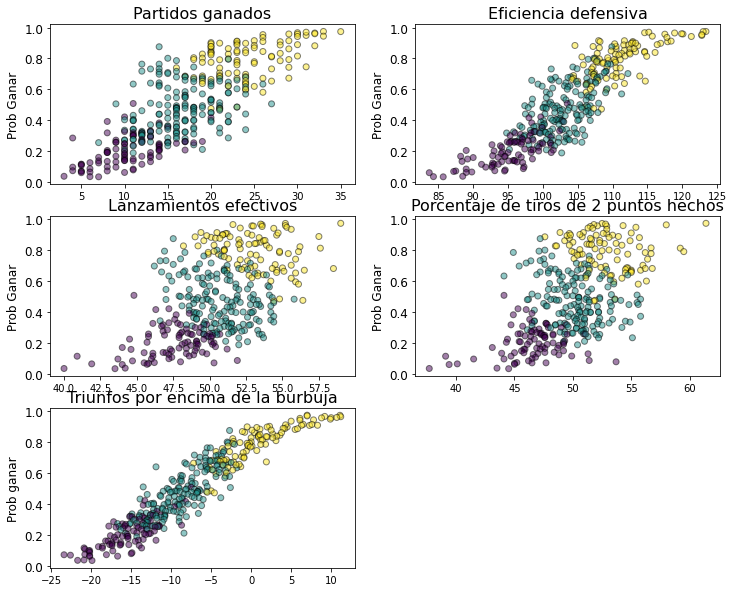

In [16]:
# Relacion con probabilidad de ganar por cluster
plt.figure(figsize=(12,10))

plt.subplot(321)
plt.scatter(y=datos['BARTHAG'], x=datos['W'],c=datos['cluster'],alpha=0.5, edgecolor='k')
plt.yticks(fontsize=12)
plt.ylabel('Prob Ganar', fontsize=12)
plt.title('Partidos ganados', fontsize=16)

plt.subplot(322)
plt.scatter(y=datos['BARTHAG'], x=datos['ADJOE'],c=datos['cluster'],alpha=0.5, edgecolor='k')
plt.yticks(fontsize=12)
plt.ylabel('Prob Ganar', fontsize=12)
plt.title('Eficiencia defensiva', fontsize=16)


plt.subplot(323)
plt.scatter(y=datos['BARTHAG'], x=datos['EFG_O'],c=datos['cluster'],alpha=0.5, edgecolor='k')
plt.yticks(fontsize=12)
plt.ylabel('Prob Ganar', fontsize=12)
plt.title('Lanzamientos efectivos', fontsize=16)


# Partidos ganados
plt.subplot(324)
plt.scatter(y=datos['BARTHAG'], x=datos['2P_O'],c=datos['cluster'],alpha=0.5, edgecolor='k')
plt.ylabel('Prob Ganar', fontsize=12)
plt.yticks(fontsize=12)
plt.title('Porcentaje de tiros de 2 puntos hechos', fontsize=16)


plt.subplot(325)
plt.scatter(y=datos['BARTHAG'], x=datos['WAB'],c=datos['cluster'],alpha=0.5, edgecolor='k')
plt.ylabel('Prob ganar', fontsize=12)
plt.yticks(fontsize=12)
plt.title('Triunfos por encima de la burbuja', fontsize=16)




plt.show()

In [17]:
from k_means import KMeans

In [32]:
model = KMeans(max_iter = 500, tolerance = 0.001, k = 3, runs = 100)
(clusters, data) = model.fit(km_scale)

In [33]:
#['W','ADJOE','BARTHAG','EFG_O','2P_O','WAB']
km_scale

array([[ 2.49556925,  2.86217223,  1.90457765,  2.86224391,  3.37695893,
         2.07913073],
       [ 2.80974042,  2.80511144,  1.90141118,  1.56728827,  0.72659873,
         2.65574628],
       [ 2.33848367,  2.22023839,  1.86578838,  1.02204379,  2.36446178,
         2.66981008],
       ...,
       [-2.21699822, -2.1163813 , -1.80177721, -2.18126753, -1.95354079,
        -1.84466777],
       [-1.74574147, -2.71551954, -1.81048501, -3.61253429, -3.68074182,
        -1.95717812],
       [-1.58865589, -2.51580679, -1.81523472, -2.41981199, -1.65574751,
        -1.70402983]])

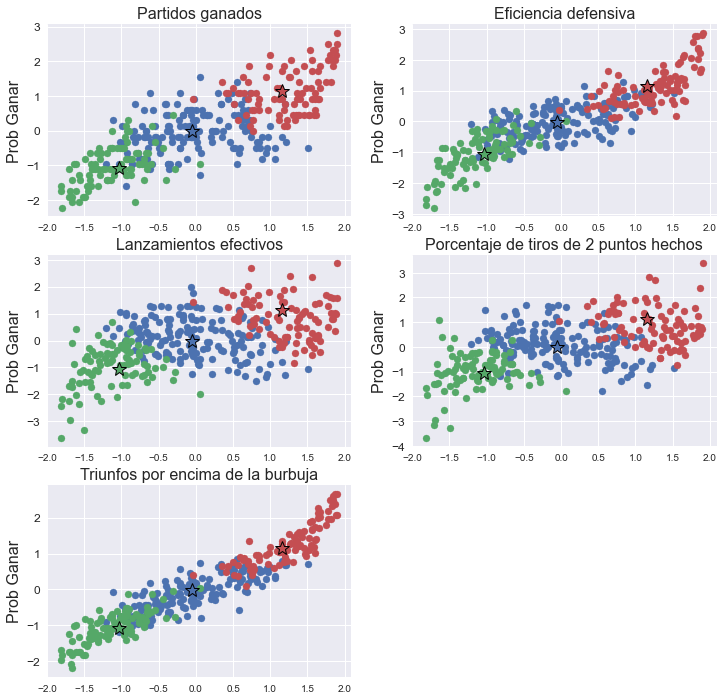

In [44]:
# Relacion con probabilidad de ganar por cluster
plt.close()
plt.figure(figsize=(12,12))
plt.subplot(321)
for i, cluster_mean in enumerate(clusters):
    data_cluster_i = data[ data[:, -1] == i ]
    plt.scatter(data_cluster_i[:, 2], data_cluster_i[:, 0], label = 'Cluster ' + str(i))
    plt.plot(cluster_mean[0], cluster_mean[1], label = 'Centroid ' + str(i), marker='*', markersize=15, markeredgecolor="k", markeredgewidth=1)
plt.yticks(fontsize=12)
plt.ylabel('Prob Ganar', fontsize=16)
plt.title('Partidos ganados', fontsize=16)

plt.subplot(322)
for i, cluster_mean in enumerate(clusters):
    data_cluster_i = data[ data[:, -1] == i ]
    plt.scatter(data_cluster_i[:, 2], data_cluster_i[:, 1], label = 'Cluster ' + str(i))
    plt.plot(cluster_mean[0], cluster_mean[1], label = 'Centroid ' + str(i), marker='*', markersize=15, markeredgecolor="k", markeredgewidth=1)
plt.yticks(fontsize=12)
plt.ylabel('Prob Ganar', fontsize=16)
plt.title('Eficiencia defensiva', fontsize=16)

plt.subplot(323)
for i, cluster_mean in enumerate(clusters):
    data_cluster_i = data[ data[:, -1] == i ]
    plt.scatter(data_cluster_i[:, 2], data_cluster_i[:, 3], label = 'Cluster ' + str(i))
    plt.plot(cluster_mean[0], cluster_mean[1], label = 'Centroid ' + str(i), marker='*', markersize=15, markeredgecolor="k", markeredgewidth=1)
plt.yticks(fontsize=12)
plt.ylabel('Prob Ganar', fontsize=16)
plt.title('Lanzamientos efectivos', fontsize=16)

plt.subplot(324)
for i, cluster_mean in enumerate(clusters):
    data_cluster_i = data[ data[:, -1] == i ]
    plt.scatter(data_cluster_i[:, 2], data_cluster_i[:, 4], label = 'Cluster ' + str(i))
    plt.plot(cluster_mean[0], cluster_mean[1], label = 'Centroid ' + str(i), marker='*', markersize=15, markeredgecolor="k", markeredgewidth=1)
plt.yticks(fontsize=12)
plt.ylabel('Prob Ganar', fontsize=16)
plt.title('Porcentaje de tiros de 2 puntos hechos', fontsize=16)


plt.subplot(325)
for i, cluster_mean in enumerate(clusters):
    data_cluster_i = data[ data[:, -1] == i ]
    plt.scatter(data_cluster_i[:, 2], data_cluster_i[:, 5], label = 'Cluster ' + str(i))
    plt.plot(cluster_mean[0], cluster_mean[1], label = 'Centroid ' + str(i), marker='*', markersize=15, markeredgecolor="k", markeredgewidth=1)
plt.yticks(fontsize=12)
plt.ylabel('Prob Ganar', fontsize=16)
plt.title('Triunfos por encima de la burbuja', fontsize=16)

plt.show()